In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import defaultdict
from torchvision import datasets
from torch.distributions import Categorical 
from torch.utils.data import DataLoader
from IPython.display import clear_output

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


'''
TODO: 

1. early stop
2. output node chosing by opt_cell
3. open Self_Attn (too slow)
'''

'\nTODO: \n\n1. early stop\n2. output node chosing by opt_cell\n3. open Self_Attn (too slow)\n'

In [2]:
class args(object):
    
    ### Fetching ###
    fetching_dim = 64
    num_weights = 10
    num_cells = 10
    num_act_fns = 4
    num_putways = 4
    num_opt = 5
    
    num_bns = 5
    num_attns = 2
    num_fetching_steps = 7 # [retr, opt, bn, act, attn, retur, put]
    
    ### ActorCritic ###
    emb_dim = 20
    LSTM_dim = 200
    
    ### Data ###
    img_channel = 1
    img_size = 28
    y_dim = 10
    eps = 1e-8
    
    ### Training ###
    discount = 0.9
    epoch = 150
    batch_size = 5 #64
    shared_lr = 0.0002
    controller_lr = 0.0002
    
    shared_maxsteps = 5 #200
    controller_maxsteps = 5 #200
    
    baseline_decay = 0.95
    val_test_steps = 5
    
    shared_grad_norm = None
    controller_grad_norm = None

    reward_c = 80
    
    critic_coef = 0.5
    entropy_coef = 1e-4
    
to_img= T.Compose([T.ToPILImage()])
to_tensor = T.Compose([T.ToTensor()])
load_norm = T.Compose([T.Resize((args.img_size,args.img_size)),
                       T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])

In [3]:
class Flatten(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self,x):
        return (x.view(x.size(0),-1))

class Self_Attn(nn.Module):
    def __init__(self, dim):
        super(Self_Attn, self).__init__()
        self.dim = dim
        
        self.query_conv = nn.Conv2d(dim, dim//8, 1)
        self.key_conv = nn.Conv2d(dim, dim//8, 1)
        self.value_conv = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.sm = nn.Softmax(dim= -1)
    
    def forward(self, x):
        
        batch_size, C, width, height = x.size()
        N = width * height
        query_out = self.query_conv(x).view(batch_size, -1, N).permute(0, 2, 1) 
        key_out = self.key_conv(x).view(batch_size, -1, N) 
        attn = self.sm(torch.bmm(query_out, key_out)) 
        value_out = self.value_conv(x).view(batch_size, -1, N) 
        out = torch.bmm(value_out, attn.permute(0,2,1)).view(batch_size, C, width, height)
        out = self.gamma * out + x
        
        return out

In [4]:
class CNNCell(nn.Module):
    def __init__(self, dim = 32, num_conv = 5, num_bn = 5, num_cells = 5):
        super().__init__()
        
        '''
        The dim has to be more than 8
        '''
        
        self.num_cells = num_cells
        self.convs = nn.ModuleList()
        self.convs.extend([nn.Conv2d(dim, dim, 3, 1, 1) for _ in range(num_conv)])
        
        self.act_funcs = nn.ModuleList()
        self.act_funcs.extend([nn.Sigmoid(),
                               nn.ReLU(inplace=True),
                               nn.LeakyReLU(0.2,inplace=True),
                               nn.Tanh(),
                              ])
        
        self.BNs = nn.ModuleList()
        self.BNs.append(nn.BatchNorm2d(dim, affine= False))
        self.BNs.extend([nn.BatchNorm2d(dim) for _ in range(num_conv-1)])
        
        self.Attns = nn.ModuleList()
        self.Attns.extend([Self_Attn(dim) for _ in range(num_conv)])
        
        
        
    def forward(self, x, dags):
        
        cells = [x]*self.num_cells
        
        B,C,W,H = x.size()
        N = W*H
        
        for dag in dags:
            opting_cell = cells[dag['Retrieve_cell']].clone()
            if not dag['Operation'] is None:
                opting_cell = self.convs[dag['Operation']](opting_cell)
            if not dag['Attn'] is None:
                opting_cell = self.Attns[dag['Attn']](opting_cell)
            if not dag['BatchNorm'] is None: 
                opting_cell = self.BNs[dag['BatchNorm']](opting_cell)
#             if not dag['Act_fn'] is None:
#                 opting_cell = self.act_funcs[dag['Act_fn']](opting_cell)
            if dag['Put'] == 0 :
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2 :
                cells[dag['Return_cell']] = torch.bmm(opting_cell.view(-1,W,H),cells[dag['Return_cell']].view(-1,W,H).permute(0,2,1)).view(B,C,W,H)
            elif dag['Put'] == 3:
                cells[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError

        return torch.mean(torch.stack(cells,0),0)
    

In [5]:
class CNNContainer(nn.Module):
    
    def __init__(self,):
        
        '''
        For MNIST
        '''
        
        super().__init__()
        self.cnn_cell = CNNCell(args.fetching_dim, args.num_weights, args.num_bns, args.num_cells)
        
        
        self.cnn_st = nn.Sequential(
            nn.Conv2d(args.img_channel, args.fetching_dim, 1, 1, 0),
        )
        

        self.cnn_end = nn.Sequential(
            nn.Conv2d(args.fetching_dim, 1, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            Flatten(),
            nn.Linear(args.img_size*args.img_size, 10),
        )
        
        self.Loss = nn.CrossEntropyLoss()
        
    def forward(self, x, dags):
        
        input_ = self.cnn_st(x)
        
        output = self.cnn_cell(input_, dags)
        
        output = self.cnn_end(output)
        
        return output
        
    def get_loss(self, loader, dags):
        
        imgs, targets = iter(loader).next()
            
        out = self.forward(imgs, dags[0])
            
        loss = self.Loss(out, targets)
        
        return loss
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
            
        

In [6]:
# C = CNNContainer()
# C(torch.randn(5,1,28,28), dag[0]).shape
# dag = a.straight_dags()

In [7]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        '''
        ActorCrtic For CNN
        '''
        self.retr_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.opt_emb = nn.Embedding(args.num_weights + 1, args.emb_dim)
        self.bn_emb = nn.Embedding(args.num_bns +1, args.emb_dim)
        self.act_emb = nn.Embedding(args.num_act_fns + 1, args.emb_dim)
        self.attn_emb = nn.Embedding(args.num_attns + 1, args.emb_dim)
        self.put_emb = nn.Embedding(args.num_putways, args.emb_dim)
        self.return_emb = nn.Embedding(args.num_cells, args.emb_dim)
        
        self.lstm = nn.LSTMCell(args.emb_dim*args.num_fetching_steps, args.LSTM_dim)
        
        self.retr_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_cells),
            nn.Softmax(-1),
        )
        
        self.opt_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_weights + 1),
            nn.Softmax(-1),
        )
        
        self.bn_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_bns + 1),
            nn.Softmax(-1),
        )
        
        self.act_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_act_fns - 1),
            nn.Softmax(-1),
        )
        
        
        self.attn_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_attns + 1),
            nn.Softmax(-1),
        )
        
        self.put_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_putways),
            nn.Softmax(-1),
        )
        
        self.return_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4 ,args.num_cells),
            nn.Softmax(-1),
        )
        
        self.critic = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.ReLU(),
            nn.Linear(args.LSTM_dim //4 , 1)
        )
        
        self.apply(self.weight_init)
        
    def forward(self, x, hidden = None ):
        
        '''
        # (Retrieve, opt(0~args.num_weight), BN(0~args.num_weight), Act_fn(0~args.num_act_fns), 
        Attn(0~args.num_Attn, Return, Put(0~args.num_putways-1))
        
        in short: [retr, opt, bn, act, attn, retur, put]
        '''
    
        retr_e = self.retr_emb(x[:,0])
        opt_e = self.opt_emb(x[:,1])
        bn_e = self.bn_emb(x[:,2])
        act_e = self.act_emb(x[:,3])
        attn_e = self.attn_emb(x[:,4])
        return_e = self.return_emb(x[:,5])
        put_e = self.put_emb(x[:,6])
        
        lstm_input = torch.cat([retr_e, opt_e, bn_e, act_e, attn_e, return_e, put_e],1)
        
        h, c = self.lstm(lstm_input, hidden)
       
        retr_dist = Categorical(self.retr_net(h))
        opt_dist = Categorical(self.opt_net(h))
        bn_dist = Categorical(self.bn_net(h))
        act_dist = Categorical(self.act_net(h))
        attn_dist = Categorical(self.attn_net(h))
        return_dist = Categorical(self.return_net(h))
        put_dist = Categorical(self.put_net(h))
        
        dists = (retr_dist, opt_dist, bn_dist, act_dist, attn_dist, return_dist, put_dist)
        value = self.critic(h)
        
        return dists , (h,c), value
    
    def weight_init(self,m):
        if type(m) in [nn.Linear]:
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0.1)
            
    def sample(self, x, hidden = None, with_detials = False):
        
        dists, hidden, value = self.forward(x, hidden)
        
        retr_dist, opt_dist, bn_dist, act_dist, attn_dist, return_dist, put_dist = dists 
        
        retr = retr_dist.sample()
        opt = opt_dist.sample()
        bn = bn_dist.sample()
        act = act_dist.sample()
        attn = attn_dist.sample()
        retur = return_dist.sample()
        put = put_dist.sample()
        
        samples = torch.stack([retr, opt, bn, act, attn, retur, put],1)
        
        if with_detials:
            
            entropy = torch.stack([retr_dist.entropy(), opt_dist.entropy(), bn_dist.entropy(),
                        act_dist.entropy(), attn_dist.entropy(), return_dist.entropy(),
                        put_dist.entropy()],-1)

            retr_logprob = retr_dist.log_prob(retr)
            opt_logprob = opt_dist.log_prob(opt)
            bn_logprob = bn_dist.log_prob(bn)
            act_logprob = act_dist.log_prob(act)
            attn_logprob = attn_dist.log_prob(attn)
            return_logprob = return_dist.log_prob(retur)
            put_log_prob = put_dist.log_prob(put)
            
            log_probs = torch.stack([retr_logprob, opt_logprob, bn_logprob, act_logprob, attn_logprob,
                                     return_logprob, put_log_prob],1)
            
            return samples, hidden, entropy, log_probs, value
        
        return samples, hidden
    
    def generate_dags(self, samples):
        
        # [retr, opt, bn, act, attn, retur, put]
        
        dags = []
        for sample in samples:
            dag_dict = {}
            
            dag_dict['Retrieve_cell'] = sample[0].item()
            
            if sample[1] == 0:
                dag_dict['Operation'] = None
            else:
                dag_dict['Operation'] = sample[1].item() - 1
                
            if sample[2] == 0:
                dag_dict['BatchNorm'] = None
            else:
                dag_dict['BatchNorm'] = sample[2].item() - 1
                
            if sample[3] == 0:
                dag_dict['Act_fn'] = None
            else:
                dag_dict['Act_fn'] = sample[3].item() - 1
                
            if sample[4] == 0:
                dag_dict['Attn'] = None
            else:
                dag_dict['Attn'] = sample[4].item() - 1
                
            dag_dict['Return_cell'] = sample[5].item()

            dag_dict['Put'] = sample[6].item()
            
            dags.append(dag_dict)
            
        return dags
    
    def straight_dags(self, x = None, hidden = None, num_steps = 5 , batch_size = 1, with_details = False):
        
        if x is None:
            x = torch.zeros(batch_size,7).long()
        
        sample_list = []
        entropies = []
        log_probs = []
        values = []
        
        for _ in range(args.num_opt): 
            
            if with_details:
                x, hidden, entropy, log_prob, value = self.sample(x, hidden, with_detials = True)
                entropies.append(entropy)
                log_probs.append(log_prob)
                values.append(value)
                
            else:
                x, hidden = self.sample(x, hidden)    
                
            sample_list.append(x)
            
        samples = torch.stack(sample_list,1)
        
        dags_dict_list = []
        
        for dag in samples:
            # batch_order 
            dags_dict_list.append(self.generate_dags(dag))
        
            
        if with_details: 
            return dags_dict_list, torch.stack(entropies,1).sum(-1).squeeze().unsqueeze(-1), torch.stack(log_probs,1).squeeze(),torch.stack(values,1).squeeze().unsqueeze(-1)
    
        return dags_dict_list
        

In [8]:
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    rewards = [0] * (values.size(0)-1) + [rewards]
    values = torch.cat([values,torch.tensor([[0.]])],0)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1]  - values[step] # Remove the gamma in here?
        gae = delta + gamma * tau * gae # -value[step] will be used in the GAE step
        returns.insert(0, gae + values[step]) # put the new one at the first, cuz we are calculating the A_GAE inversely.
    return torch.stack(returns,0) # cuz we need the gradient of value, so we have to + value[step]

In [9]:
class FetchingNAS(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.shared = CNNContainer()
        self.controller = ActorCritic()
        self.training_loader = DataLoader(datasets.MNIST('../GANs/data/mnist',
                                    train= True, download=False,
                                    transform = load_norm),
                                    batch_size= args.batch_size,
                                    shuffle=True)
        self.valid_loader = DataLoader(datasets.MNIST('../GANs/data/mnist',
                                    train= False, download=False,
                                    transform = load_norm),
                                    batch_size= args.batch_size,
                                    shuffle=True)
        
        self.shared_optim = optim.Adam(self.shared.parameters(), lr = args.shared_lr)
        self.controller_optim = optim.SGD(self.controller.parameters(), lr = args.controller_lr)
        
        self.CE = nn.CrossEntropyLoss()
        self.max_R = None
        self.best_dag = None
        self.smaple_init = torch.zeros(1,7)
        self.controller_hist = defaultdict(list)
        
    def train_shared(self,):
        
        self.shared.train()
        self.controller.eval()
        
        step = 0
        
        while step < args.shared_maxsteps:
            
            self.shared_optim.zero_grad()
            
            dags = self.controller.straight_dags(num_steps = args.num_opt)
            
            loss = self.shared.get_loss(self.training_loader, dags)
            
            loss.backward()
            if not args.shared_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.shared.parameters(), args.shared_grad_norm)
            
            self.shared_optim.step()
            
            step += 1 
    
    def get_reward(self, dags, entropies,):
        
        loss = 0
        
        for i in range(args.val_test_steps):
            
            loss += self.shared.get_loss(self.valid_loader, dags)
            
        loss /= args.val_test_steps
        
        loss_ppl = loss.exp()
        
        R = (args.reward_c / ((loss_ppl ** 2) + args.eps)) # * torch.ones_like(entropies)
        
        return R
        
        # If we sample a dag a time, then change the structure of sampling dag    
            
    def train_controller(self,):
        
        self.controller.train()
        
        step = 0
        
#         baseline = None
        
        while step < args.controller_maxsteps:
            
            self.controller_optim.zero_grad()
            
            dags, entropy, log_prob, value = self.controller.straight_dags(num_steps = args.num_opt ,with_details = True)
        
            with torch.no_grad():
                
                R = self.get_reward(dags, entropy)
                
            if self.max_R is None:
                self.max_R = R.max()
                self.best_dag = dags[0]
            else:
                if R.max() > self.max_R:
                    self.max_R = R.max()
                    self.best_dag = dags[0]
                    
            self.R = R
             
            self.controller_hist['Rewards'].append(R.item())
                
#             if baseline is None:
#                 baseline = R
#             else:
#                 baseline = args.baseline_decay * baseline + (1 - args.baseline_decay) * R
            
            returns = compute_gae(R, value)
            
            adv = returns.detach() - value 
            
            actor_loss = (- log_prob * adv).mean()
            
            critic_loss = adv.pow(2).mean()
            
            loss = actor_loss + args.critic_coef * critic_loss - args.entropy_coef * entropy.mean()
            
            loss.backward()
            
            if not args.controller_grad_norm is None:
                nn.utils.clip_grad_norm_(self.controller.parameters(), args.controller_grad_norm)
            
            self.controller_optim.step()
            
            step += 1
        
    
    def train(self, n_epoch):

        for self.epoch in range(n_epoch):
            
            self.train_shared()
            
            # Trian the shared model's parameter for shared_maxsteps

            self.train_controller()
            
            self.plot_controller_hist('Training')
            
            # Train controller for controler_maxsteps
            
    def plot_controller_hist(self, step):
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in self.controller_hist.keys():
            plt.plot(self.controller_hist[name], label = name)
            plt.xlabel('Number of Steps',fontsize=15)
            plt.ylabel( name, fontsize=15)
            plt.title(name, fontsize=30, fontweight ="bold")
            plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png")
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
 

In [10]:
F = FetchingNAS()

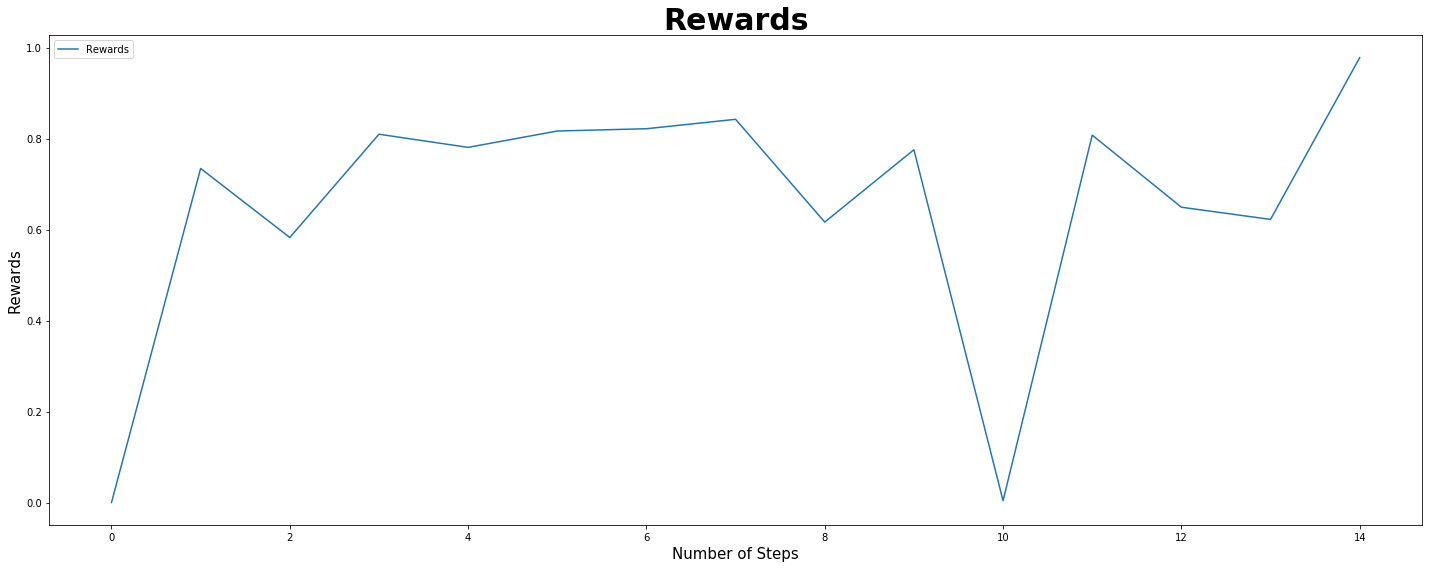

In [11]:
F.train(3)

In [12]:
def dags_translate(dags):
    for dag in dags:
        if dag['Act_fn'] == 0:
            dag['Act_fn'] = 'Sigmoid'
        elif dag['Act_fn'] == 1:
            dag['Act_fn'] = 'ReLU'
        elif dag['Act_fn'] == 2:
            dag['Act_fn'] = 'LeakyReLU'
        elif dag['Act_fn'] == 3:
            dag['Act_fn'] = 'Tanh'
        if dag['Put'] == 0:
            dag['Put'] = 'Plus'
        elif dag['Put'] == 1:
            dag['Put'] = 'Emlement_Wise*'
        elif dag['Put'] == 2:
            dag['Put'] = 'Bmm'
        elif dag['Put'] == 3:
            dag['Put'] = 'Inplace'
    return dags

In [13]:
dags_translate(F.best_dag)

[{'Retrieve_cell': 3,
  'Operation': 3,
  'BatchNorm': 2,
  'Act_fn': 'Sigmoid',
  'Attn': 0,
  'Return_cell': 7,
  'Put': 'Plus'},
 {'Retrieve_cell': 8,
  'Operation': 0,
  'BatchNorm': None,
  'Act_fn': 'Sigmoid',
  'Attn': None,
  'Return_cell': 5,
  'Put': 'Bmm'},
 {'Retrieve_cell': 8,
  'Operation': 3,
  'BatchNorm': 2,
  'Act_fn': 'Sigmoid',
  'Attn': None,
  'Return_cell': 9,
  'Put': 'Emlement_Wise*'},
 {'Retrieve_cell': 8,
  'Operation': 7,
  'BatchNorm': 2,
  'Act_fn': None,
  'Attn': 0,
  'Return_cell': 7,
  'Put': 'Bmm'},
 {'Retrieve_cell': 4,
  'Operation': 7,
  'BatchNorm': 2,
  'Act_fn': 'Sigmoid',
  'Attn': None,
  'Return_cell': 2,
  'Put': 'Plus'}]